Source https://www.r-bloggers.com/linear-regression-with-correlated-data/ , https://www.quantumforest.com/wp-content/uploads/2011/10/unemployment.txt

I started following the debate on differential minimum wage for youth (15-19 year old) and adults in New Zealand. Eric Crampton has written a nice series of blog posts, making the data from Statistics New Zealand available. I will use the nzunemployment.csv data file (with quarterly data from March 1986 to June 2011) and show an example of multiple linear regression with autocorrelated residuals in R.

A first approach could be to ignore autocorrelation and fit a linear model that attempts to predict youth unemployment with two explanatory variables: adult unemployment (continuous) and minimum wage rules (categorical: equal or different). This can be done using:

In [ ]:
data = read.csv('nzunemployment.csv', header = TRUE)
 
# Create factor for minimum wage, which was different for youth
# and adults before quarter 90 (June 2008)
data$minwage = factor(ifelse(data$q < 90, 'Different', 'Equal'))

In [2]:
str(data)

'data.frame':	102 obs. of  6 variables:
 $ quarter: Factor w/ 102 levels "Dec-00","Dec-01",..: 63 38 89 12 64 39 90 13 65 40 ...
 $ q      : int  1 2 3 4 5 6 7 8 9 10 ...
 $ adult  : num  3.21 3.13 3.11 3.01 3.19 ...
 $ youth  : num  12.4 11.3 10.9 11.7 11.7 ...
 $ lf1519 : num  223 206 197 208 211 ...
 $ minwage: Factor w/ 2 levels "Different","Equal": 1 1 1 1 1 1 1 1 1 1 ...


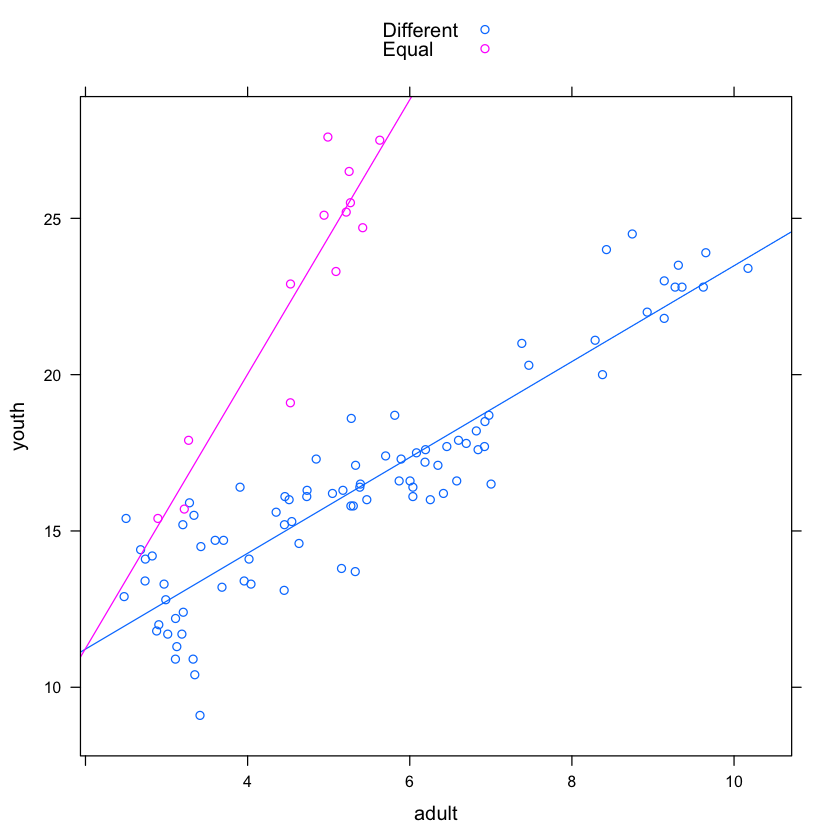

In [20]:
# And a scatterplot
library(lattice)
xyplot(youth ~ adult, group=minwage, data = data, 
       type=c('p', 'r'), auto.key = TRUE)

In [1]:
# Simple Model with all interactions (adult*minwage = adult + minwage + adult:minwage)
mod1 = lm(youth ~ adult*minwage, data = data)
summary(mod1)


Call:
lm(formula = youth ~ adult * minwage, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.2859 -0.7809 -0.0300  0.9186  3.4128 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)         8.15314    0.43328  18.817  < 2e-16 ***
adult               1.53334    0.07506  20.428  < 2e-16 ***
minwageEqual       -5.69192    2.19356  -2.595   0.0109 *  
adult:minwageEqual  2.85518    0.46197   6.180 1.47e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.447 on 98 degrees of freedom
Multiple R-squared:  0.8816,	Adjusted R-squared:  0.878 
F-statistic: 243.3 on 3 and 98 DF,  p-value: < 2.2e-16


We can make the coefficients easier to understand if we center adult unemployment on the mean of the first 80 quarters. Notice that we get the same slope, Adj-R2, etc. but now the intercept corresponds to the youth unemployment for the average adult unemployment before changing minimum wage rules. All additional analyses will use the centered version.

In [7]:
# Centered Data

data$cadult = with(data, adult - mean(adult))
mod2 = lm(youth ~ cadult*minwage, data = data)
summary(mod2)


Call:
lm(formula = youth ~ cadult * minwage, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.2859 -0.7809 -0.0300  0.9186  3.4128 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)         16.28209    0.15352  106.06  < 2e-16 ***
cadult               1.53334    0.07506   20.43  < 2e-16 ***
minwageEqual         9.44472    0.52629   17.95  < 2e-16 ***
cadult:minwageEqual  2.85518    0.46197    6.18 1.47e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.447 on 98 degrees of freedom
Multiple R-squared:  0.8816,	Adjusted R-squared:  0.878 
F-statistic: 243.3 on 3 and 98 DF,  p-value: < 2.2e-16


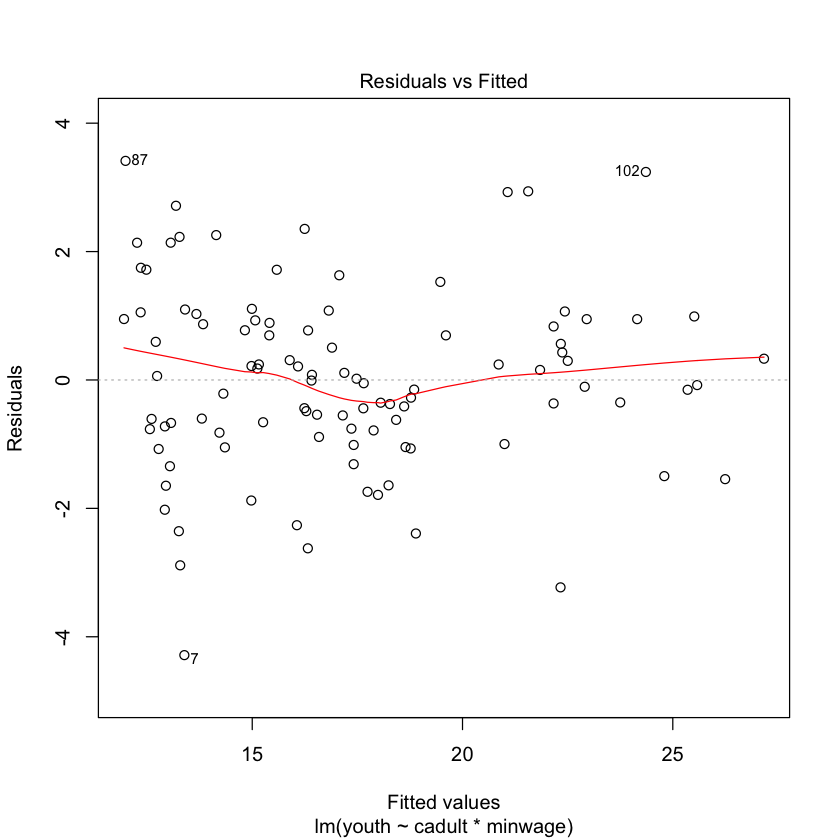

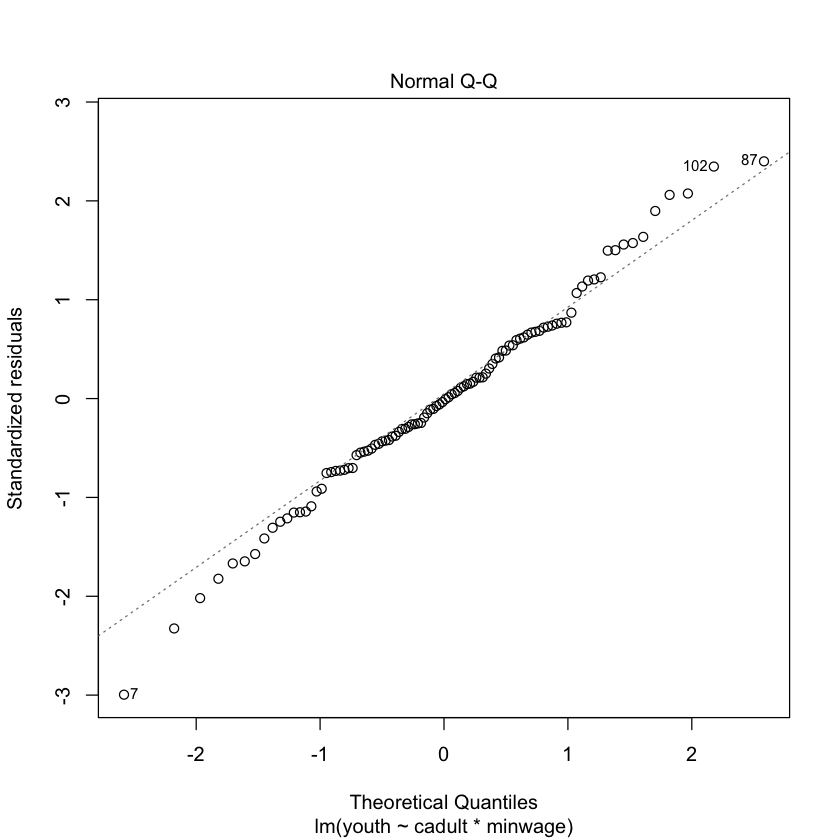

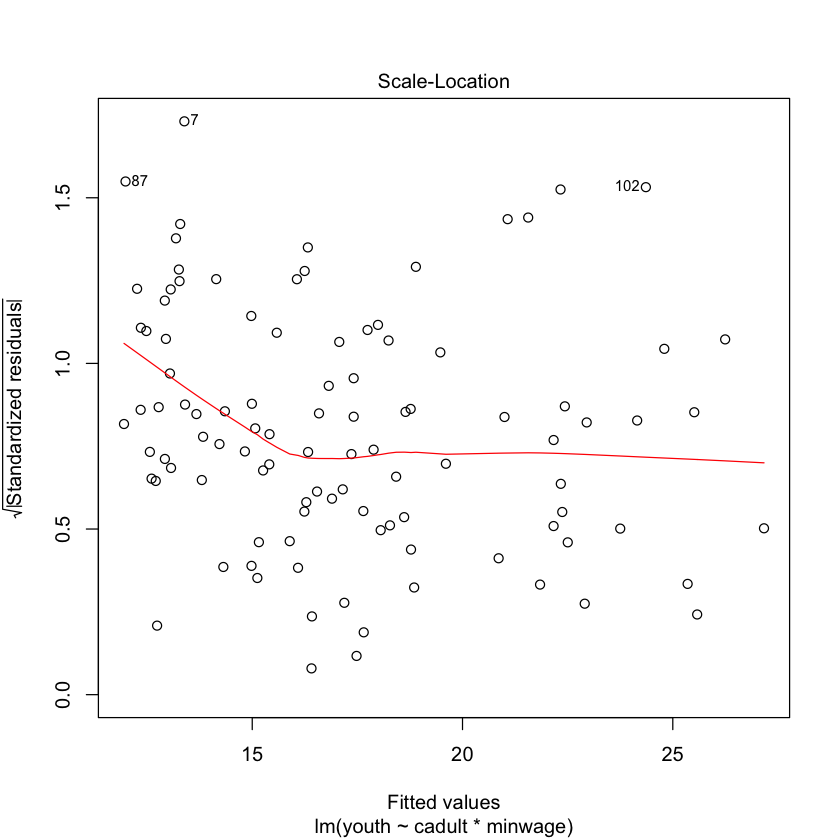

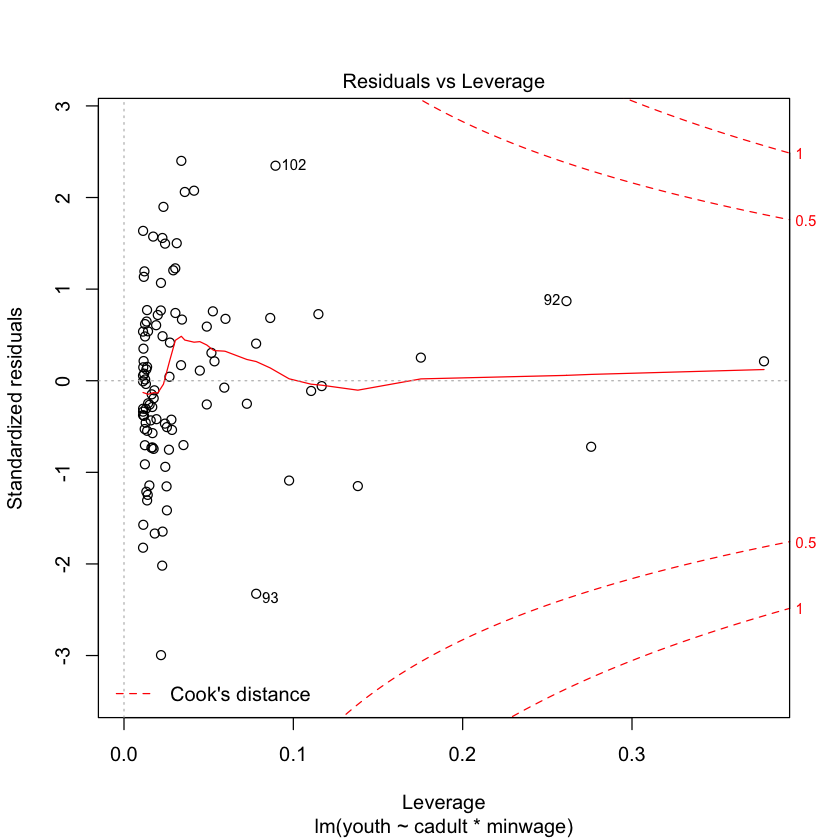

In [9]:
plot(mod2)    # Plots residuals for the model fit


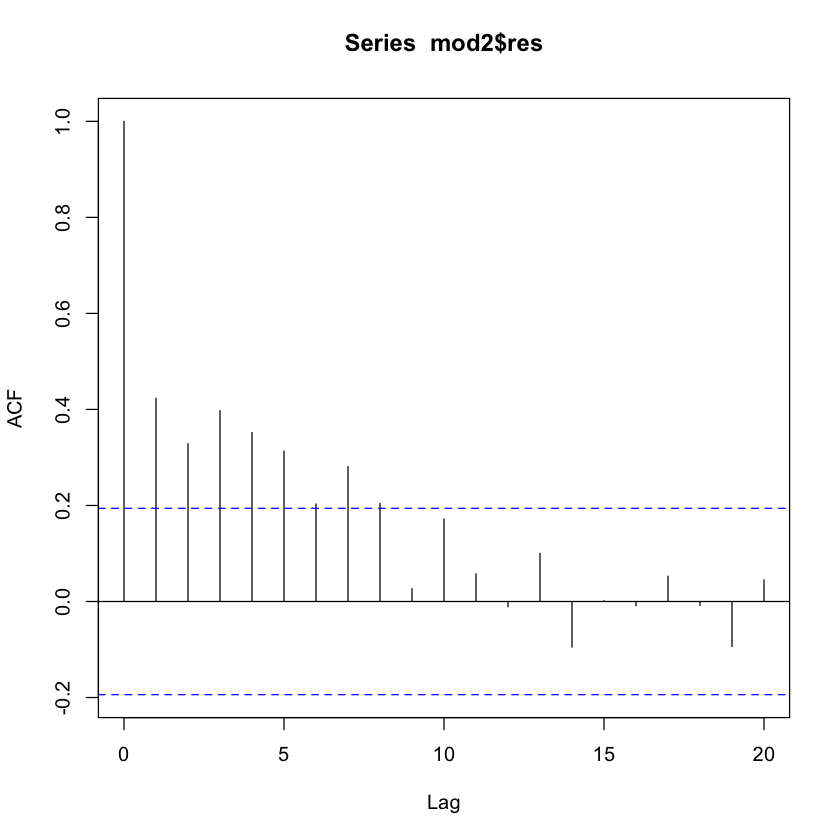

Note: In the centered version, the intercept corresponds to youth unemployment when adult unemployment rate is 5.4 (average for the first 89 quarters). The coefficient of minwageEqual corresponds to the increase of youth unemployment (9.44%) when the law moved to have equal minimum wage for youth and adults. Notice that the slopes did not change at all.

I will use the function gls() from the nlme package (which comes by default with all R installations) to take into account the serial correlation. First we can fit a model equivalent to mod2, just to check that we get the same results.

In [14]:
summary(mod2) # from above I don't like scrolling. 


Call:
lm(formula = youth ~ cadult * minwage, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.2859 -0.7809 -0.0300  0.9186  3.4128 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)         16.28209    0.15352  106.06  < 2e-16 ***
cadult               1.53334    0.07506   20.43  < 2e-16 ***
minwageEqual         9.44472    0.52629   17.95  < 2e-16 ***
cadult:minwageEqual  2.85518    0.46197    6.18 1.47e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.447 on 98 degrees of freedom
Multiple R-squared:  0.8816,	Adjusted R-squared:  0.878 
F-statistic: 243.3 on 3 and 98 DF,  p-value: < 2.2e-16


In [15]:
library(nlme)   # We will use GLS aka generalized least squares to solve the same problem
mod3 = gls(youth ~ cadult*minwage, data = data)
summary(mod3)

Generalized least squares fit by REML
  Model: youth ~ cadult * minwage 
  Data: data 
       AIC      BIC    logLik
  375.7722 388.6971 -182.8861

Coefficients:
                        Value Std.Error   t-value p-value
(Intercept)         16.282089 0.1535237 106.05585       0
cadult               1.533341 0.0750595  20.42834       0
minwageEqual         9.444719 0.5262926  17.94576       0
cadult:minwageEqual  2.855184 0.4619725   6.18042       0

 Correlation: 
                    (Intr) cadult mnwgEq
cadult              -0.048              
minwageEqual        -0.292  0.014       
cadult:minwageEqual  0.008 -0.162  0.568

Standardized residuals:
        Min          Q1         Med          Q3         Max 
-2.96256631 -0.53975848 -0.02071559  0.63499262  2.35900240 

Residual standard error: 1.446696 
Degrees of freedom: 102 total; 98 residual

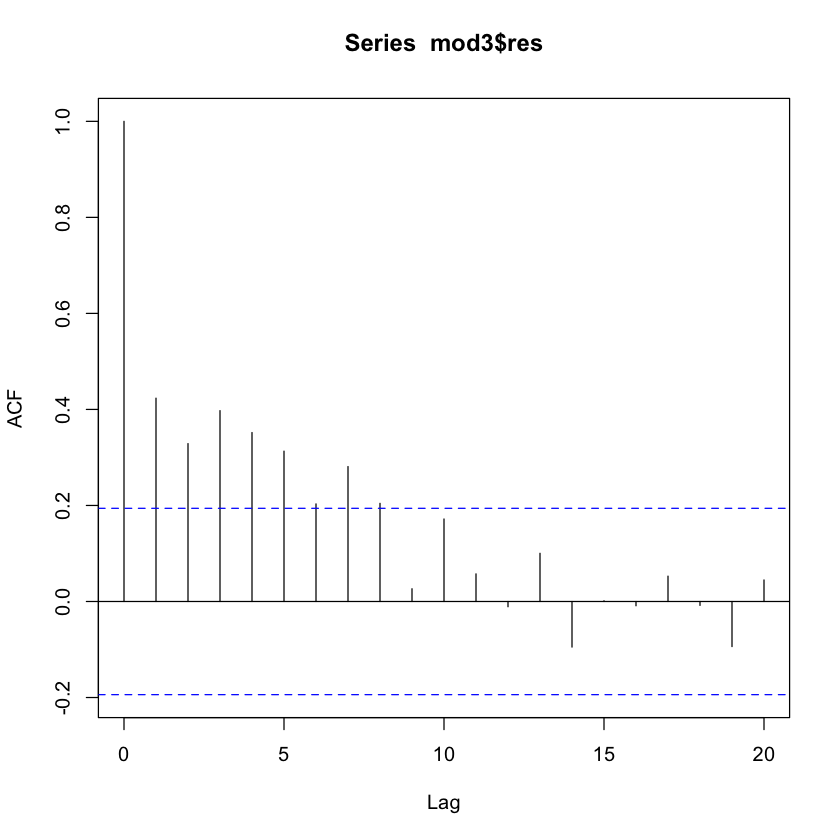

In [12]:
acf(mod3$res) # Now Let's look at the autocorrelation of the residuals. PROBLEM!!!

To get rid of this pesky autocorrelation, we can add an autoregressive process of order 1 for the residuals and compare the two models:

In [16]:
mod4 = gls(youth ~ cadult*minwage,
           correlation = corAR1(form=~1), data = data)
summary(mod4)

Generalized least squares fit by REML
  Model: youth ~ cadult * minwage 
  Data: data 
       AIC      BIC    logLik
  353.0064 368.5162 -170.5032

Correlation Structure: AR(1)
 Formula: ~1 
 Parameter estimate(s):
      Phi 
0.5012431 

Coefficients:
                        Value Std.Error  t-value p-value
(Intercept)         16.328637 0.2733468 59.73598       0
cadult               1.522192 0.1274453 11.94389       0
minwageEqual         9.082626 0.8613543 10.54459       0
cadult:minwageEqual  2.545011 0.5771780  4.40940       0

 Correlation: 
                    (Intr) cadult mnwgEq
cadult              -0.020              
minwageEqual        -0.318  0.007       
cadult:minwageEqual -0.067 -0.155  0.583

Standardized residuals:
        Min          Q1         Med          Q3         Max 
-2.89233359 -0.55460580 -0.02419759  0.55449166  2.29571080 

Residual standard error: 1.5052 
Degrees of freedom: 102 total; 98 residual

In [18]:
anova(mod3, mod4)

,call,Model,df,AIC,BIC,logLik,Test,L.Ratio,p-value
,<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
mod3,"gls(model = youth ~ cadult * minwage, data = data)",1,5,375.7722,388.6971,-182.8861,,NA,NA
mod4,"gls(model = youth ~ cadult * minwage, data = data, correlation = corAR1(form = ~1))",2,6,353.0064,368.5162,-170.5032,1 vs 2,24.7658,6.473595e-07
